<a href="https://colab.research.google.com/github/atahanoezer/Wind/blob/main/Kelmarsh_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.0 MB/s eta 0:00:00


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor
import optuna

from catboost import  EShapCalcType, EFeaturesSelectionAlgorithm


In [27]:
# # Do this if you are using the datasets from your drive
from google.colab import drive
drive.mount('/content/drive/'
)
# # for feat select
from google.colab import output
output.enable_custom_widget_manager()

In [5]:
! git clone https://github.com/atahanoezer/Wind.git

Cloning into 'Wind'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 260 (delta 17), reused 13 (delta 4), pack-reused 221
Receiving objects: 100% (260/260), 20.17 MiB | 12.27 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [6]:
from Wind.dataset import Dataset
from Wind.utils import score_function
from Wind.model import *

In [7]:
import warnings
warnings.filterwarnings('ignore') # to avoid catboost and pd warnings

## TEMP

In [53]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import  mean_squared_error,mean_absolute_error


class Model:
	def __init__(
		self,
		model_function: str = "cb",
		params: dict = {},
		prediction_type: str = "one_shot",
	) -> None:
		"""
		Initialize the Model object.

		Parameters
		----------
			model_function (str, optional):
				Model function to use ("cb" for CatBoost or "lgb" for LightGBM). Defaults to "cb".

			params (dict, optional):
				 Parameters for the model function. Defaults to {}.

			prediction_type (str, optional):
				 Type of prediction ("one_shot" or "recursive"). Defaults to "one_shot".


		Attributes
		----------
			model_function : str
				Model function to use ("cb" for CatBoost or "lgb" for LightGBM)
			params : dict
				Parameters for the model function
			prediction_type : str
				Type of prediction ("one_shot" or "recursive")
			model : object
				Trained model object
		"""
		self.model_function = (
			CatBoostRegressor if model_function == "cb" else LGBMRegressor
		)
		self.params = params
		self.prediction_type = prediction_type

	def train(
		self,
		train_x: pd.DataFrame,
		train_y: pd.DataFrame,
		val_x: pd.DataFrame,
		val_y: pd.DataFrame,
		multioutput: bool = False,
		verbose: int = 500,
	) -> None:
		"""
		Train the model.

		Parameters
		----------
			train_x (pd.DataFrame):
				 Training input data.

			train_y (pd.DataFrame):
				 Training target data.

			val_x (pd.DataFrame):
				 Validation input data.

			val_y (pd.DataFrame):
				 Validation target data.

			multioutput (bool, optional):
				 Flag indicating if the model supports multioutput. Defaults to False.

			verbose (int, optional):
				 Verbosity level during training. Defaults to 500.

		Returns
		-------
			None
		"""
		if multioutput:
			self.model = MultiOutputRegressor(self.model_function())
			self.model.fit(train_x, train_y, verbose=verbose)
		else:
			self.model = self.model_function(**self.params)
			self.model.fit(train_x, train_y, eval_set=(val_x, val_y), verbose=verbose)

	def predict(self, X: pd.DataFrame, horizon: int = 1) -> np.ndarray:
		"""
		Make predictions using the trained model depending on prediction type.
		Recursive prediction only supports univariate data with previous steps as features.


		Parameters
		----------
			X (pd.DataFrame):
				Input data for prediction.
			horizon (int, optional):
				Number of steps to predict into the future. Defaults to 1.

		Returns
		-------
			np.ndarray:
				Predicted values.
		"""
		if self.prediction_type == "one_shot":
			forecast = self.model.predict(X)
			return forecast
		elif self.prediction_type == "recursive":
			forecast = []
			recursive_x = X.copy()

			for _ in range(horizon):
				pred = self.model.predict(recursive_x)
				recursive_x[:, :-1] = recursive_x[:, 1:]
				recursive_x[:, -1] = pred

			forecast = np.array(pred)
			return forecast
		else:
			print("Prediction type not recognized")

	def model_summarizer(
		self,
		val_x: pd.DataFrame,
		val_y: pd.DataFrame,
		test_x: pd.DataFrame,
		test_y: pd.DataFrame,
		plots: bool = True,
		plot_steps: int = 2000,
		feat_importance: bool = True,
		feat_steps: int = 15,
		feat_names: list = None,
		horizon: int = 1,
	) -> tuple:
		"""
		Generate a summary of the model's performance.

		Parameters
		----------
			val_x (pd.DataFrame):
				 Validation input data.

			val_y (pd.DataFrame):
				 Validation target data.

			test_x (pd.DataFrame):
				 Test input data.

			test_y (pd.DataFrame):
				 Test target data.

			plots (bool, optional):
				 Flag indicating if plots should be generated. Defaults to True.

			plot_steps (int, optional):
				 Number of steps to include in the plots. Defaults to 2000.

			feat_importance (bool, optional):
				 Flag indicating if feature importance should be calculated and plotted. Defaults to True.

			feat_steps (int, optional):
				 Number of top features to display in the feature importance plot. Defaults to 15.

			feat_names (list, optional):
				 List of feature names. Defaults to None.

			horizon (int, optional):
				 Number of steps to predict into the future. Defaults to 1.

		Returns
		-------
			tuple:
				Tuple containing scores (MAE, RMSE, R2) and feature importances (if enabled).
		"""
		val_pred, test_pred = self.predict(val_x, horizon), self.predict(
			test_x, horizon
		)

		val_pred, test_pred = val_pred.reshape(-1), test_pred.reshape(-1)

		val_mae, val_rmse, val_r2 = score_function(val_y, val_pred)
		test_mae, test_rmse, test_r2 = score_function(test_y, test_pred)

		scores = pd.DataFrame(
			np.array([[val_mae, val_rmse, val_r2], [test_mae, test_rmse, test_r2]])
		)
		scores.columns = ["MAE", "RMSE", "R2"]
		scores.index = ["Validation", "Test"]
		print(scores)

		if plots:
			_, axs = plt.subplots(2, 1, figsize=(10, 8))

			# Plot the validation predictions
			axs[0].plot(
				range(plot_steps),
				val_pred[:plot_steps],
				label="Predictions",
				color="red",
			)
			axs[0].plot(
				range(plot_steps), val_y[:plot_steps], label="True", color="black"
			)
			axs[0].set_title("Validation Predictions")
			axs[0].legend()

			# Plot the test predictions
			axs[1].plot(
				range(plot_steps),
				test_pred[:plot_steps],
				label="Predictions",
				color="red",
			)
			axs[1].plot(
				range(plot_steps), test_y[:plot_steps], label="True", color="black"
			)
			axs[1].set_title("Test Predictions")
			axs[1].legend()

			# Adjust the layout and display the plot
			plt.tight_layout()
			plt.show()
		importances = None
		if feat_importance:
			# Get feature importances
			if hasattr(self.model, "feature_importances_"):
				importances = self.model.feature_importances_
			elif hasattr(self.model, "get_feature_importance"):
				importances = self.model.get_feature_importance()
			else:
				print("Model does not have feature importance attribute")

			if importances is not None:
				# Sort indices from most to least important and get corresponding names
				indices = np.argsort(importances)[::-1]
				names = [feat_names[i] for i in indices]

				# Create plot
				plt.figure(figsize=(10, 8))

				# Create plot title
				plt.title("Feature Importance")

				# Add bars
				plt.bar(range(feat_steps), importances[indices][:feat_steps])

				# Add feature names as x-axis labels
				plt.xticks(range(feat_steps), names[:feat_steps], rotation=90)

				# Show plot
				plt.show()
		return scores, importances

	def hyp_op(
			self,
			val_x: pd.DataFrame,
			val_y: pd.DataFrame,
			train_x: pd.DataFrame,
			train_y: pd.DataFrame,
			horizon: int = 1,
			trial = 30,
			task_type = 'GPU'
		) -> tuple:

			def objective(trial):
				params = {
					"iterations": 1000,
					"learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
					"depth": trial.suggest_int("depth", 1, 10),
					# "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0), # requires task type CPU
					"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
					'task_type': task_type,
				}

				self.model = self.model_function(**params)
				self.model.fit(train_x, train_y,eval_set=(val_x, val_y), silent=True)

				val_pred = self.predict(val_x, horizon)
				rmse = mean_absolute_error(val_y, val_pred.reshape(-1))

				return rmse

			study = optuna.create_study(direction='minimize')
			study.optimize(objective, n_trials=30)

			print('Best hyperparameters:', study.best_params)
			print('Best RMSE:', study.best_value)
			return study.best_params, study.best_value
	def feat_select(self,
      val_x: pd.DataFrame,
      val_y: pd.DataFrame,
      train_x: pd.DataFrame,
      train_y: pd.DataFrame,
      num_feats = 20,
      num_steps = 3
        ):
          self.model = self.model_function(**self.params)
          summary = self.model.select_features(
                  X= train_x,
                  y= train_y,
                  eval_set=(val_x, val_y),
                  features_for_select=list(range(train_x.shape[1])),
                  num_features_to_select=num_feats,
                  steps=num_steps,
                  algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
                  shap_calc_type=EShapCalcType.Regular,
                  train_final_model=True,
                  logging_level='Silent',
                  plot=True
                )

          return summary



# Data Preprocess

In [12]:
from numpy.core.multiarray import concatenate
# Change directory to the dataset
train_csv_1= '/content/drive/MyDrive/MLSES/datasets/Eng/Kelmarsh_SCADA_2018_3084/Turbine_Data_Kelmarsh_2_2018-01-01_-_2019-01-01_229.csv'
train_csv_2 = '/content/drive/MyDrive/MLSES/datasets/Eng/Kelmarsh_SCADA_2019_3085/Turbine_Data_Kelmarsh_2_2019-01-01_-_2020-01-01_229.csv'
val_csv = '/content/drive/MyDrive/MLSES/datasets/Eng/Kelmarsh_SCADA_2020_3086/Turbine_Data_Kelmarsh_2_2020-01-01_-_2021-01-01_229.csv'
test_csv = '/content/drive/MyDrive/MLSES/datasets/Eng/Kelmarsh_SCADA_2021_3087/Turbine_Data_Kelmarsh_2_2021-01-01_-_2021-07-01_229.csv'

csv_params = {'index_col':'# Date and time','parse_dates':True,'skiprows':9} # This part is copied from data provider check references

train_1 = pd.read_csv(train_csv_1,**csv_params)
train_2 = pd.read_csv(train_csv_2,**csv_params)
val = pd.read_csv(val_csv,**csv_params)
test = pd.read_csv(test_csv,**csv_params) #



concatenated_df = pd.concat([train_1,train_2,val,test]) # Concatanate test and train data
test_dates = concatenated_df[concatenated_df.index >= '2020-07-01'] # change test set to given test set
val_dates = concatenated_df[ (concatenated_df.index >= '2019-07-01') & (concatenated_df.index < '2020-07-01') ]


val_split = len(val_dates)/len(concatenated_df)
test_split = len(test_dates)/len(concatenated_df)

In [13]:
val_split,test_split

(0.28660924040720437, 0.28582615505090053)

In [14]:
# This part is also copied from data provider, fields look good in terms of statistics
use_columns = [ 'Wind speed (m/s)','Wind speed, Standard deviation (m/s)', 'Wind speed, Minimum (m/s)',
            'Wind speed, Maximum (m/s)','Wind direction (°)','Nacelle position (°)','Energy Export (kWh)','Power (kW)',
            'Reactive power (kvar)','Rotor speed (RPM)','Generator RPM (RPM)','Nacelle ambient temperature (°C)',
            'Blade angle (pitch position) A (°)','Blade angle (pitch position) B (°)','Blade angle (pitch position) C (°)',
            'Lost Production to Curtailment (Total) (kWh)','Lost Production to Downtime (kWh)','Metal particle count counter',
            'Front bearing temperature (°C)','Rear bearing temperature (°C)']

In [15]:
roll_window = 4
dataset = Dataset(concatenated_df[use_columns])
dataset.fill_nan(use_columns)
dataset.add_seasonal_feat(dataset.df, dataset.df.index)
# Rolling means selected heuristicly
dataset.apply_rolling_window(dataset.df,'Wind speed (m/s)', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'Nacelle ambient temperature (°C)', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'Generator RPM (RPM)' , roll_window,np.mean)

# Modelling



## Next Step Prediction



In [43]:
horizon = 1
window = 144

train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,target_col = 'Power (kW)',test_split= test_split,val_split = val_split)


In [44]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
feats = model.feat_select(val_x = val_x, val_y = val_y, train_x = train_x, train_y= train_y,num_feats =40)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]
# model.train(train_x, train_y, val_x, val_y)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [45]:
model.hyp_op(val_x = val_x, val_y = val_y, train_x = train_x, train_y= train_y, task_type = 'GPU')

[I 2023-08-30 13:40:41,105] A new study created in memory with name: no-name-0512aa5c-8550-4a24-981f-830be00b2960
[I 2023-08-30 13:40:49,473] Trial 0 finished with value: 253.8079005770044 and parameters: {'learning_rate': 0.0012129618925218778, 'depth': 7, 'min_data_in_leaf': 31}. Best is trial 0 with value: 253.8079005770044.
[I 2023-08-30 13:40:52,711] Trial 1 finished with value: 146.7922380197001 and parameters: {'learning_rate': 0.019710651461956868, 'depth': 3, 'min_data_in_leaf': 25}. Best is trial 1 with value: 146.7922380197001.
[I 2023-08-30 13:41:03,415] Trial 2 finished with value: 237.42767907667556 and parameters: {'learning_rate': 0.001313942802968864, 'depth': 9, 'min_data_in_leaf': 27}. Best is trial 1 with value: 146.7922380197001.
[I 2023-08-30 13:41:06,762] Trial 3 finished with value: 146.05185696465645 and parameters: {'learning_rate': 0.016250881249852408, 'depth': 4, 'min_data_in_leaf': 50}. Best is trial 3 with value: 146.05185696465645.
[I 2023-08-30 13:41:12

Best hyperparameters: {'learning_rate': 0.06991732516826366, 'depth': 6, 'min_data_in_leaf': 14}
Best RMSE: 142.9726928520692


({'learning_rate': 0.06991732516826366, 'depth': 6, 'min_data_in_leaf': 14},
 142.9726928520692)

                  MAE        RMSE        R2
Validation  93.340233  144.288533  0.954927
Test        90.286203  140.499887  0.956055


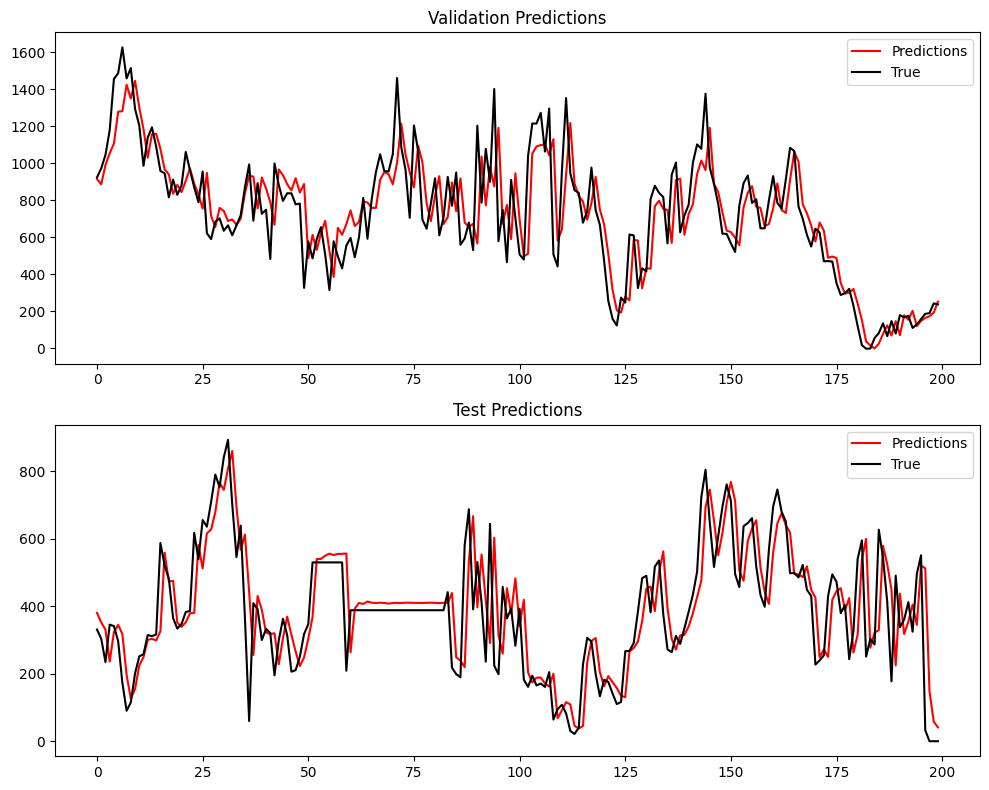

In [47]:
next_step_os,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)



## Next Hour One shot Prediction



In [48]:
horizon = 6
window = 144
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                              window, horizon,target_col = 'Power (kW)',test_split= 0.5)

In [54]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})

feats = model.feat_select(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1],num_feats =40)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]


In [55]:
model.hyp_op(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1])

[I 2023-08-30 14:03:55,679] A new study created in memory with name: no-name-b84e7bfc-2d89-4b25-904f-a941db5d7986
[I 2023-08-30 14:04:09,189] Trial 0 finished with value: 181.16800419191011 and parameters: {'learning_rate': 0.011191571158726689, 'depth': 10, 'min_data_in_leaf': 84}. Best is trial 0 with value: 181.16800419191011.
[I 2023-08-30 14:04:13,814] Trial 1 finished with value: 180.7593165841925 and parameters: {'learning_rate': 0.012380438662816504, 'depth': 4, 'min_data_in_leaf': 79}. Best is trial 1 with value: 180.7593165841925.
[I 2023-08-30 14:04:18,406] Trial 2 finished with value: 180.34665312194727 and parameters: {'learning_rate': 0.02395206967950089, 'depth': 4, 'min_data_in_leaf': 59}. Best is trial 2 with value: 180.34665312194727.
[I 2023-08-30 14:04:21,826] Trial 3 finished with value: 223.90272172918816 and parameters: {'learning_rate': 0.001763775181143949, 'depth': 4, 'min_data_in_leaf': 90}. Best is trial 2 with value: 180.34665312194727.
[I 2023-08-30 14:04:

Best hyperparameters: {'learning_rate': 0.02395206967950089, 'depth': 4, 'min_data_in_leaf': 59}
Best RMSE: 180.34665312194727


({'learning_rate': 0.02395206967950089, 'depth': 4, 'min_data_in_leaf': 59},
 180.34665312194727)

                   MAE        RMSE        R2
Validation  181.242793  263.121241  0.816282
Test        183.336634  265.649124  0.851328


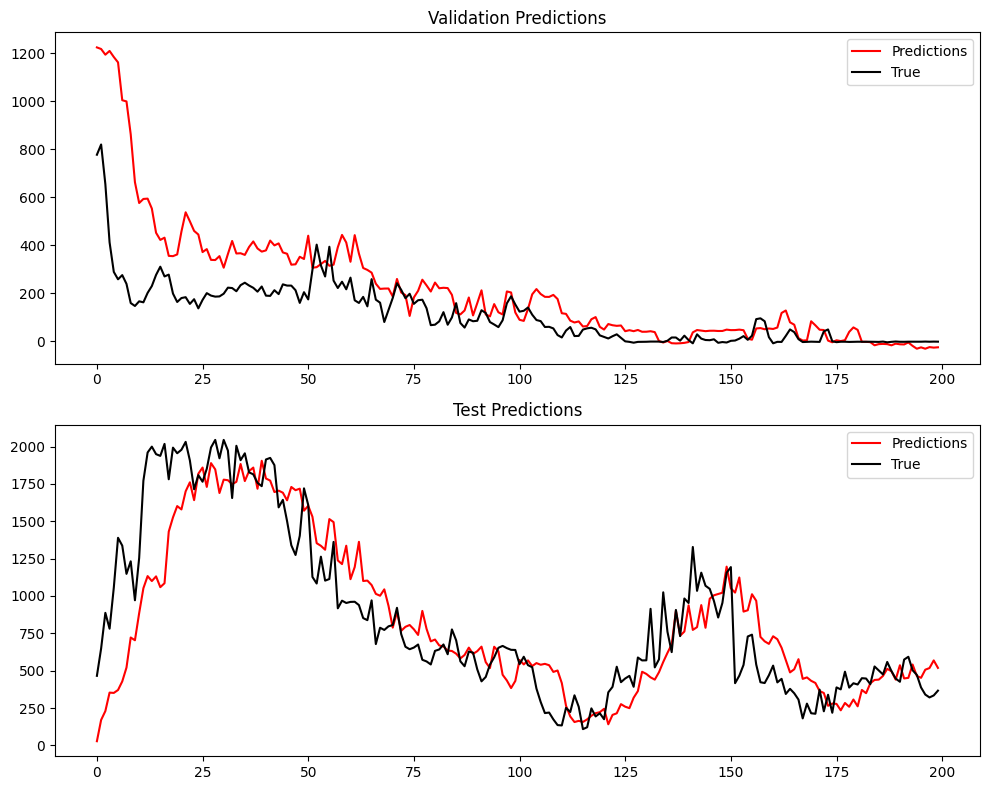

In [56]:
next_hour_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)



## Next Day One Shot Prediction



In [60]:
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     144, 144,target_col ='Power (kW)',test_split= 0.5)

In [61]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})

feats = model.feat_select(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1],num_feats =40)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [62]:
model.hyp_op(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1])

[I 2023-08-30 14:13:17,252] A new study created in memory with name: no-name-79017382-7199-4947-8889-687c6b90757c
[I 2023-08-30 14:13:21,713] Trial 0 finished with value: 450.5460605319408 and parameters: {'learning_rate': 0.0024872737448356896, 'depth': 7, 'min_data_in_leaf': 20}. Best is trial 0 with value: 450.5460605319408.
[I 2023-08-30 14:13:28,866] Trial 1 finished with value: 448.01967310623587 and parameters: {'learning_rate': 0.0028889110963913893, 'depth': 6, 'min_data_in_leaf': 51}. Best is trial 1 with value: 448.01967310623587.
[I 2023-08-30 14:13:32,894] Trial 2 finished with value: 454.5264498605149 and parameters: {'learning_rate': 0.0015610436106281637, 'depth': 6, 'min_data_in_leaf': 85}. Best is trial 1 with value: 448.01967310623587.
[I 2023-08-30 14:13:40,863] Trial 3 finished with value: 451.51056408988205 and parameters: {'learning_rate': 0.0020930429697367634, 'depth': 7, 'min_data_in_leaf': 82}. Best is trial 1 with value: 448.01967310623587.
[I 2023-08-30 14:

Best hyperparameters: {'learning_rate': 0.009842823656861944, 'depth': 2, 'min_data_in_leaf': 55}
Best RMSE: 442.1231222364492


({'learning_rate': 0.009842823656861944, 'depth': 2, 'min_data_in_leaf': 55},
 442.1231222364492)

                   MAE        RMSE        R2
Validation  453.826147  558.904156  0.172222
Test        521.399051  629.771245  0.164587


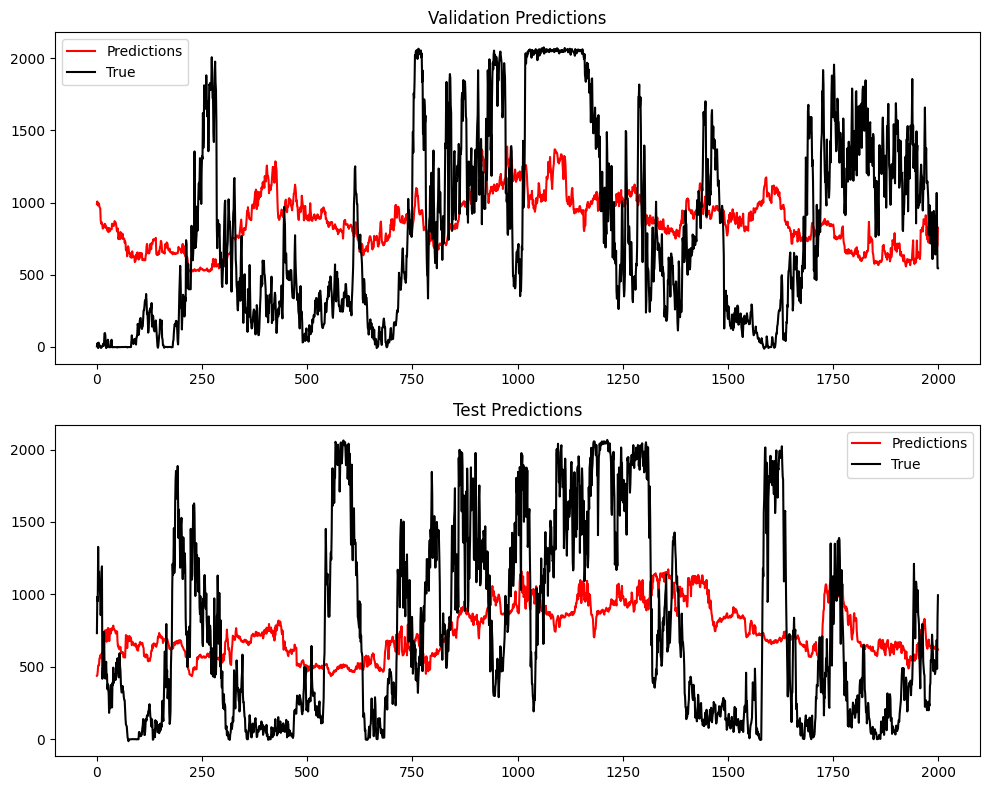

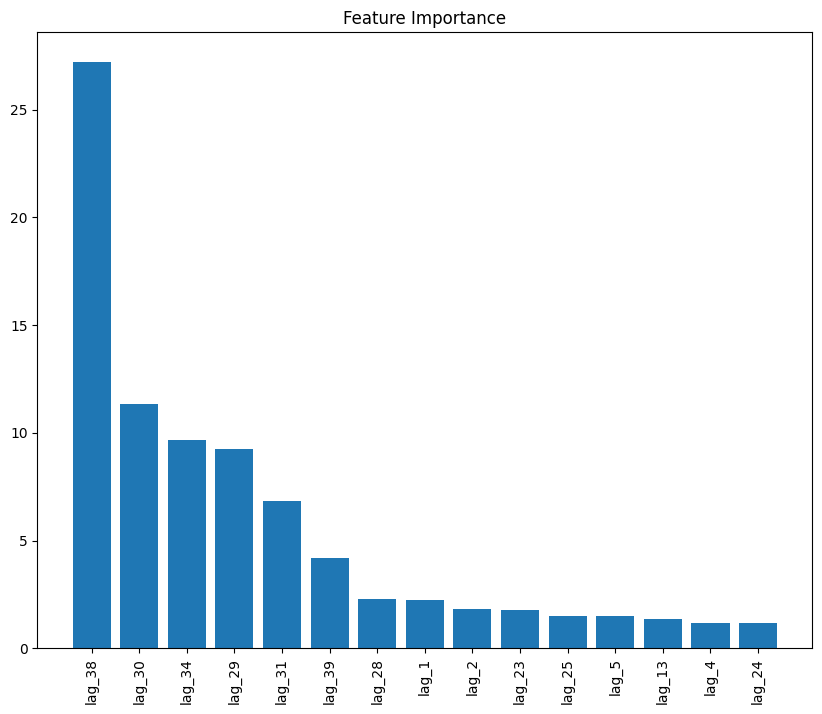

In [64]:
next_day_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=2000, feat_importance=True, feat_steps=15,feat_names= columns)

# Result Comparison

In [35]:
from tabulate import tabulate

results = [next_step_os.iloc[1,:],next_hour_os.iloc[1,:],next_day_os.iloc[1,:],
           next_hour_rec.iloc[1,:],next_day_rec.iloc[1,:]]

names = ['Next Step One Shot', 'Next Hour One Shot', 'Next Day One Shot',
         'Next Hour Recursive', 'Next Day Recursive']
metrics = ['MAE', 'RMSE', 'R2']

header = ['Metric'] + metrics
table_data = []

# Append MAE, RMSE, and R2 values for the test set

for i,n in enumerate(names):
  value = [n] + [results[i]['MAE']] + [results[i]['RMSE']]+ [results[i]['R2']]
  table_data.append(value)
table = tabulate(table_data, headers=header, tablefmt='pipe')
print(table)

| Metric              |     MAE |    RMSE |       R2 |
|:--------------------|--------:|--------:|---------:|
| Next Step One Shot  |  90.858 | 140.833 | 0.955847 |
| Next Hour One Shot  | 188.798 | 267.333 | 0.849437 |
| Next Day One Shot   | 528.362 | 636.239 | 0.147338 |
| Next Hour Recursive | 109.745 | 162.144 | 0.944611 |
| Next Day Recursive  | 188.5   | 288.387 | 0.824822 |
